# Fresnel Defocus Recovery

In this notebook we will illustrate using `dLux` to measure a telescope's distance from true focus in the Fresnel regime. We will first generate a Fresnel out-of-focus PSF using the STScI optics package `poppy` (example from [here](https://poppy-optics.readthedocs.io/en/latest/figures/README%20Figure.html)), and then retrieve the parameters of this using `dLux`.

First, we import the relevant packages.

In [14]:
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib as mpl

import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as np

import equinox as eqx
import optax

import functools as ft # used for filtering
from tqdm import tqdm

import poppy 

plt.rcParams['figure.dpi'] = 120
plt.rcParams['image.cmap'] = 'hot'
plt.rcParams["text.usetex"] = 'true'

from dLux.base import *
from dLux.layers import *
from dLux.propagators import *

Define `poppy` model parameters:

In [15]:
wl = 1.5e-6 # m
aperture = 2.4 # m
pixsize_arcsec = 0.013
fov_arcsec = 3.0
wf_npix = 1024       
det_npix = np.round(2*fov_arcsec/pixsize_arcsec).astype(int)

We will load a `poppy` model of the HST:

In [16]:
# Set up poppy optical system
hst_osys_p = poppy.OpticalSystem()
hst_aper = poppy.CompoundAnalyticOptic(opticslist=[
    poppy.SecondaryObscuration(secondary_radius=0.3, n_supports=4, support_width=0.1),
    poppy.CircularAperture(radius=aperture/2)])
hst_osys_p.add_pupil(hst_aper)
hst_osys_p.add_detector(pixelscale=pixsize_arcsec, fov_arcsec=fov_arcsec)

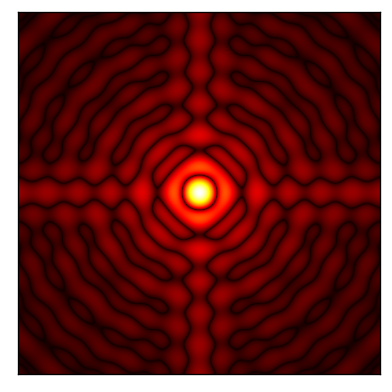

In [17]:
# Generate poppy PSF and get the aperture array to apply to our mode
hst_fits, intermediates = hst_osys_p.calc_psf(wl, return_intermediates=True)
hst_psf_p = np.flipud(np.flipud(hst_fits[0].data).T) # Flip to match ∂Lux
hst_ap = np.array(intermediates[0].amplitude) # Take aperture for ∂Lux
osamp = intermediates[-1].oversample

plt.imshow(hst_psf_p**0.25)
plt.xticks([])
plt.yticks([]);

### ∂Lux

Now we create our `dLux` optical system. We can simply read in the pupil array from the `poppy` model - consider this if you have existing code to model your telescope!

In [18]:
# Define approximate fl and pixelsize, we will optimise the fl to match poppy

fl = 57.6  # approximate fl, to be inferred
det_pixsize = 4e-9 # approximate value, fixed

hst_layers = [
    CreateWavefront(wf_npix, wf_npix),
    ApplyAperture(hst_ap),
    NormaliseWavefront(),
    PhysicalMFT(pixels_out=det_npix, focal_length=fl, 
        pixel_scale_out=det_pixsize, inverse=False)]

wavels = np.array([wl])
hst = OpticalSystem(hst_layers, wavels=wavels)
psf = hst()

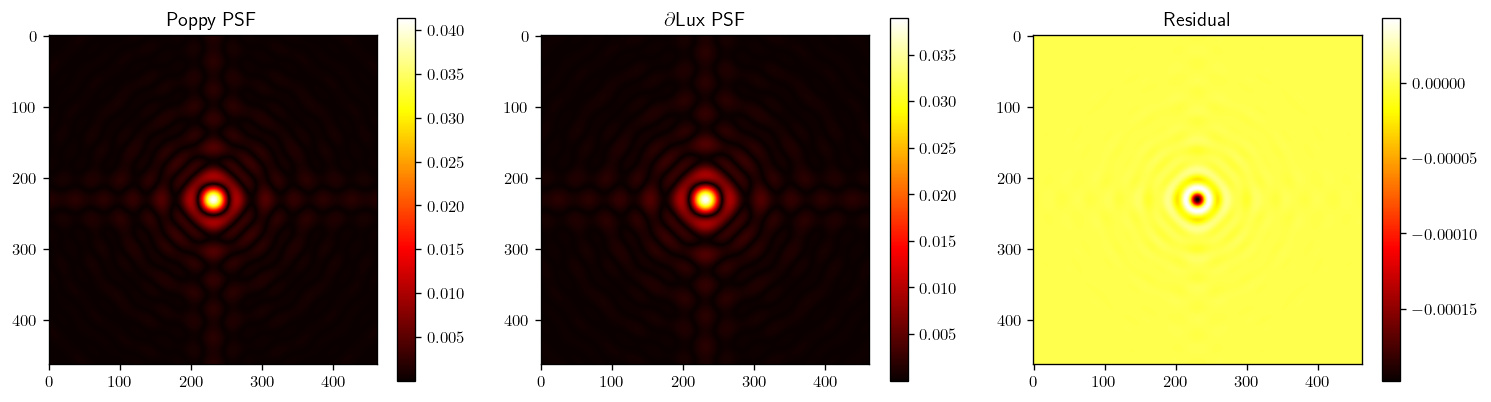

In [19]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Poppy PSF")
plt.imshow(hst_psf_p**0.5)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("$\partial$Lux PSF")
plt.imshow(psf**0.5)
plt.colorbar()

norm = psf - hst_psf_p
plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(norm)
plt.colorbar()
plt.show()

---

## Optimisation

So now we need to set up our optimisation objects. `dLux` allows us to use the Jax optimization package `optax`, which is very powerful (but has slightly challenging syntax).

Firstly we need to define which parameters we want to optimise; this is done by creating a `filter_spec` object. This can be thought of as a binary mask defining which parameters to optimise, that is not applied to an array, but an arbitrary `dLux` model. 

We initialise this by defaulting all values to False:

```python
 filter_spec = jax.tree_map(lambda _: False, model)
```

We can then change the individual paramaters we want to optimise to `True`. In this example we only want to optimise the focal length, so we use this syntax:

```python
filter_spec = eqx.tree_at(lambda scene: scene.layers[3].focal_length, filter_spec, replace=True)
```

After that, all we need to do is define our loss function and pass the `filter_spec` to our loss function decorators, and initialise our `optax` algorithm. In this example we will use an Adam optimiser with a learning rate of 100. This is relatively straightfoward and the syntax of the next few cells can be applied generally to all single-parameter optimisations.

In [20]:
# Set up Optimisation
filter_spec = jax.tree_map(lambda _: False, hst)
filter_spec = eqx.tree_at(lambda scene: scene.layers[3].focal_length, filter_spec, replace=True)

In [21]:
@eqx.filter_jit
@ft.partial(eqx.filter_value_and_grad, filter_spec=filter_spec)
def loss_func(model, data):
    out = model()
    return np.sum(np.square(data - out))

/Users/benjaminpope/opt/anaconda3/envs/dlux/lib/python3.9/site-packages/equinox-0.5.4-py3.9.egg/equinox/grad.py:71: UserWarning: For brevity the `filter_spec` argument has been renamed `arg`
  warnings.warn("For brevity the `filter_spec` argument has been renamed `arg`")


In [28]:
%%time
_ = loss_func(hst, hst_psf_p) # Compile
print("Initial Loss: {}".format(_[0]))

Initial Loss: 6.090345202112706e-06
CPU times: user 1.19 s, sys: 18.4 ms, total: 1.21 s
Wall time: 218 ms


In [37]:
model = OpticalSystem(hst_layers, wavels=wavels)
optim = optax.adam(0.5)
opt_state = optim.init(model)

errors, grads_out, models_out = [], [], []

with tqdm(range(200),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_func(model, hst_psf_p)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        models_out.append(model)
        errors.append(loss)
        grads_out.append(grads)
        t.set_description('log-loss %.5f' % (np.log10(loss))) # update the progress bar


log-loss -14.34156: 100%|█████████████████████| 200/200 [00:44<00:00,  4.53it/s]


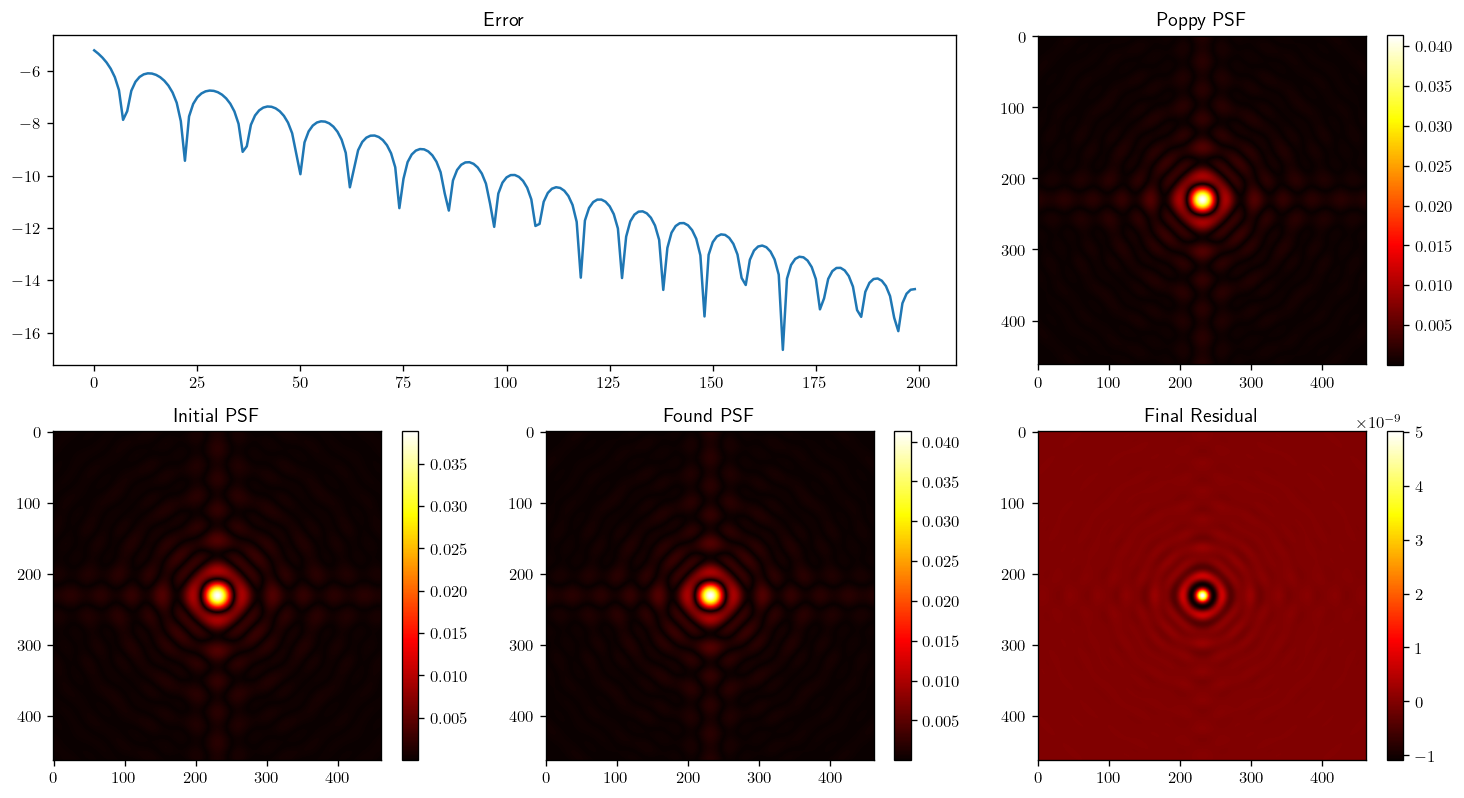

In [38]:
initial_psf = hst()
final_psf = model()

plt.figure(figsize=(15, 8))

plt.subplot(2, 3, (1,2))
plt.title("Error")
plt.plot(np.arange(len(errors)), np.log10(np.array(errors)))
# plt.plot(np.arange(len(errors)), np.array(errors))


plt.subplot(2, 3, 3)
plt.title("Poppy PSF")
plt.imshow(hst_psf_p**0.5)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.title("Initial PSF")
plt.imshow(initial_psf**0.5)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Found PSF")
plt.imshow(final_psf**0.5)
plt.colorbar()

plt.subplot(2, 3, 6)
residual = hst_psf_p-final_psf
plt.title("Final Residual")
plt.imshow(residual)
plt.colorbar()
plt.show()

Let's look at the history of the focal length parameter:

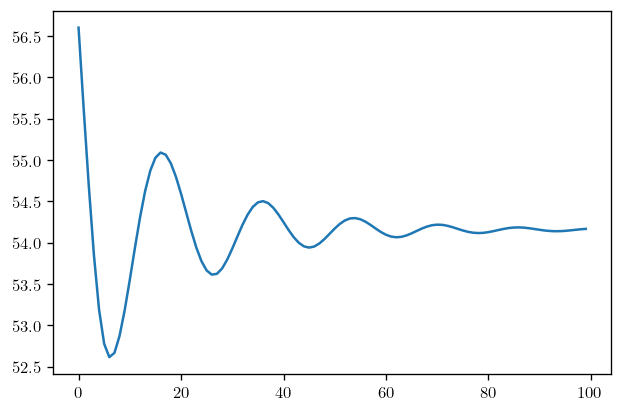

In [35]:
fls = [o.layers[3].focal_length for o in models_out]
# plt.plot(np.log10(np.array(fls)))
plt.plot(fls)

In [41]:
print('Is our reconstructed PSF everywhere close to the input?',np.allclose(hst_psf_p, final_psf),'!')

Is our reconstructed PSF everywhere close to the input? True !


Beauty! As we can see we have found the equivalent focal length required to match the poppy psf, and the difference between the two is at the machine precision level!

### HST Fresnel Model

In [74]:
# HST example - Following example in PROPER Manual V2.0 page 49.
import astropy.units as u 

diam = 2.4 * u.m
fl_pri = 5.52085 * u.m
d_pri_sec = 4.907028205 * u.m
fl_sec = -0.6790325 * u.m
d_sec_to_focus = 6.3919974 * u.m

hstf = poppy.FresnelOpticalSystem(pupil_diameter=2.4*u.m, npix=512, beam_ratio=0.25)
m1 = poppy.QuadraticLens(fl_pri, name='Primary')
m2 = poppy.QuadraticLens(fl_sec, name='Secondary')

hstf.add_optic(poppy.CircularAperture(radius=diam.value/2))
hstf.add_optic(poppy.SecondaryObscuration(secondary_radius=0.396,
                                 support_width=0.0264,
                                 support_angle_offset=45.0))
hstf.add_optic(m1)
hstf.add_optic(m2, distance=d_pri_sec)
hstf.add_optic(poppy.ScalarTransmission(planetype=poppy.fresnel.PlaneType.image, name='focus'), 
               distance=d_sec_to_focus);


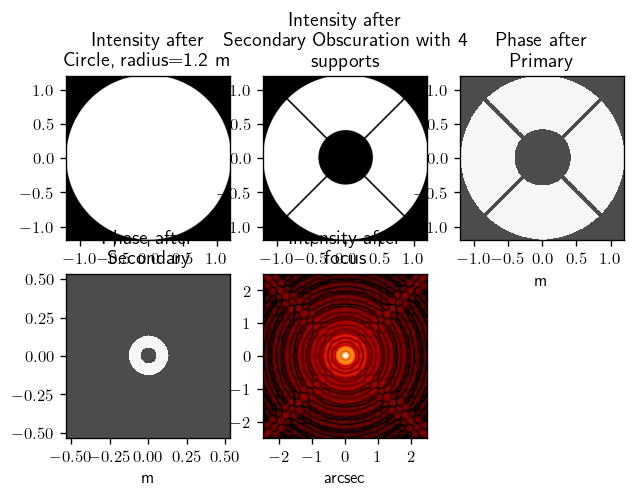

In [75]:
psf, waves = hstf.calc_psf(wavelength=wl, display_intermediates=True, return_intermediates=True)
